In [69]:

import os
import numpy as np
import sys
import re
import math
import matplotlib.pyplot as plt
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')


In [ ]:
sys.path[0]

In [ ]:
os.listdir(sys.path[0]+"/dutch radar")

In [ ]:
#too big latent space
#gradually reduce dropout on skip connections, first dont use them
#perceptual loss

In [11]:
import h5py
filename = 'RAD_NL60_VOL_NA_201701200000.h5'
f = h5py.File(sys.path[0]+"/radar/"+filename, 'r')
list(f.keys())

['geographic',
 'image1',
 'overview',
 'radar1',
 'scan1',
 'scan10',
 'scan11',
 'scan12',
 'scan13',
 'scan14',
 'scan2',
 'scan3',
 'scan4',
 'scan5',
 'scan6',
 'scan7',
 'scan8',
 'scan9',
 'visualisation1',
 'visualisation2',
 'visualisation3']

In [12]:
list(f.values())

[<HDF5 group "/geographic" (1 members)>,
 <HDF5 group "/image1" (0 members)>,
 <HDF5 group "/overview" (0 members)>,
 <HDF5 group "/radar1" (0 members)>,
 <HDF5 group "/scan1" (6 members)>,
 <HDF5 group "/scan10" (6 members)>,
 <HDF5 group "/scan11" (6 members)>,
 <HDF5 group "/scan12" (6 members)>,
 <HDF5 group "/scan13" (6 members)>,
 <HDF5 group "/scan14" (6 members)>,
 <HDF5 group "/scan2" (6 members)>,
 <HDF5 group "/scan3" (6 members)>,
 <HDF5 group "/scan4" (6 members)>,
 <HDF5 group "/scan5" (6 members)>,
 <HDF5 group "/scan6" (6 members)>,
 <HDF5 group "/scan7" (6 members)>,
 <HDF5 group "/scan8" (6 members)>,
 <HDF5 group "/scan9" (6 members)>,
 <HDF5 group "/visualisation1" (1 members)>,
 <HDF5 group "/visualisation2" (1 members)>,
 <HDF5 group "/visualisation3" (1 members)>]

In [13]:
n1 = f.get('geographic')

In [101]:
n1 = f.get('scan5')
list(n1.keys())

['calibration',
 'scan_TX_power',
 'scan_V_data',
 'scan_W_data',
 'scan_Z_data',
 'scan_uZ_data']

<IPython.core.display.Javascript object>


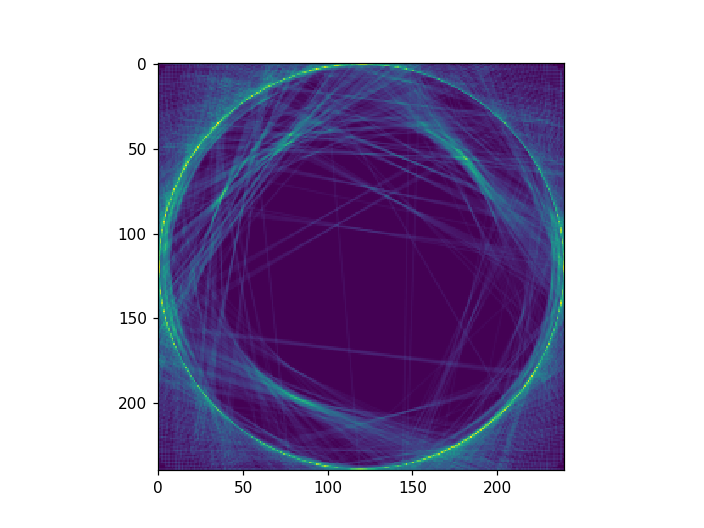

In [102]:
%matplotlib notebook
plt.imshow(np.concatenate([n1["scan_Z_data"][100:,:], n1["scan_Z_data"][:100,:]]))

In [105]:
sinogram = n1["scan_Z_data"][:]

In [119]:
def backproject(sinogram, angles):
    """
    Backproject a given sinogram.
    Hints:
    Perform the backprojection inversely to the way we did the
    forwardprojection, by smearing each projection in the sinogram back along
    the axis that you summed before in forwardproject() (you can use for
    example numpy.tile() for this), then rotating the resulting backprojection
    to get the right backprojection angle.
    Use scipy.ndimage.rotate(...,...,reshape=False)
    Using roundmask helps to improve the result.
    """
    # calculate number of projections, and pixels
    Nproj, Npix = np.shape(sinogram)
    # define empty container for reconstruction of sample
    reconstruction = np.zeros((Npix, Npix))

    for proj in np.arange(Nproj):  # loop over all projections
        sys.stdout.write("\r Reconstructing: %03i/%i" % (proj+1, Nproj))
        sys.stdout.flush()

        backprojection = np.tile(sinogram[proj, :], (Npix, 1))
        #backprojection /= Npix  # Just normalization
        rotated_backprojection = nd.rotate(backprojection, angles[proj], reshape=False)

        # Add the rotated backprojection multiplied with a roundmask
        reconstruction += rotated_backprojection

    return reconstruction

In [120]:
Nangles = 360
angles = np.linspace(0, 360, Nangles, False)
angles

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [121]:
import scipy.ndimage as nd

original = backproject(sinogram, angles)

 Reconstructing: 360/360

In [130]:
sinogram.shape

(360, 240)

In [129]:
original.shape

(240, 240)

In [131]:
np.concatenate([original, sinogram],axis = -1).shape

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [124]:
np.arange(55)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54])

In [125]:
?np.tile

In [126]:
?nd.rotate

In [132]:
import tensorflow as tf; print(tf.__version__)

ImportError: Could not find 'cudnn64_7.dll'. TensorFlow requires that this DLL be installed in a directory that is named in your %PATH% environment variable. Note that installing cuDNN is a separate step from installing CUDA, and this DLL is often found in a different directory from the CUDA DLLs. You may install the necessary DLL by downloading cuDNN 7 from this URL: https://developer.nvidia.com/cudnn

In [2]:
import cv2

In [1]:
import cv2 as cv
import numpy as np
cap = cv.VideoCapture("vtest.avi")
ret, frame1 = cap.read()
prvs = cv.cvtColor(frame1,cv.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255
while(1):
    ret, frame2 = cap.read()
    next = cv.cvtColor(frame2,cv.COLOR_BGR2GRAY)
    flow = cv.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv.normalize(mag,None,0,255,cv.NORM_MINMAX)
    bgr = cv.cvtColor(hsv,cv.COLOR_HSV2BGR)
    cv.imshow('frame2',bgr)
    k = cv.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        cv.imwrite('opticalfb.png',frame2)
        cv.imwrite('opticalhsv.png',bgr)
    prvs = next
cap.release()
cv.destroyAllWindows()

error: OpenCV(4.0.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [90]:
def dense_optical_flow(im1, im2, pyr_scale=0.5, levels=3, winsize=5, 
                       iterations=3, poly_n=5, poly_sigma=1.2, fb_threshold=-1, 
                       mask1=None, mask2=None, 
                       flow1=None, flow2=None): 

    if flow1 is None: 
        fflow = cv2.calcOpticalFlowFarneback(to_gray(im1), to_gray(im2), pyr_scale, levels, winsize, 
                                             iterations, poly_n, poly_sigma, 0)
    else: 
        fflow = cv2.calcOpticalFlowFarneback(to_gray(im1), to_gray(im2), pyr_scale, levels, winsize, 
                                             iterations, poly_n, poly_sigma, 0, flow1.copy())

    if mask1 is not None: 
        fflow[~mask1.astype(np.bool)] = np.nan

    if fb_threshold > 0: 
        H, W = im1.shape[:2]
        xs, ys = np.meshgrid(np.arange(W), np.arange(H))
        xys1 = np.dstack([xs, ys])
        xys2 = xys1 + fflow
        rflow = dense_optical_flow(im2, im1, pyr_scale=pyr_scale, levels=levels, 
                                   winsize=winsize, iterations=iterations, poly_n=poly_n, 
                                   poly_sigma=poly_sigma, fb_threshold=-1)
        if mask2 is not None: 
            rflow[~mask2.astype(np.bool)] = np.nan

        xys1r = xys2 + rflow
        fb_bad = (np.fabs(xys1r - xys1) > fb_threshold).all(axis=2)
        fflow[fb_bad] = np.nan

    return fflow 

In [211]:
import numpy as np
from scipy import signal
def optical_flow(prev, curr, window_size, tau=1e-2):
    """
    Calculates the dense optical flow x and y components between prev and curr.
    Requires import scipy signal and numpy.
    :param prev: numpy array of shape (n, h, w, 1)
    :param curr: numpy array of shape (n, h, w, 1)
    :return: 2 numpy arrays of shape (n, h, w, 1)
    """
    print("Calculating optical flow with Lucas Kanade method.")
    kernel_x = np.array([[-1., 1.], [-1., 1.]])
    kernel_y = np.array([[-1., -1.], [1., 1.]])
    kernel_t = np.array([[1., 1.], [1., 1.]])#*.25
    w = int(window_size/2) # window_size is odd, all the pixels with offset in between [-w, w] are inside the window
    # Implement Lucas Kanade
    # for each point, calculate I_x, I_y, I_t
    mode = 'same'
    u = np.zeros(prev.shape)
    v = np.zeros(prev.shape)
    # within window window_size * window_size
    for sample in range(prev.shape[0]): # loop over samples
        fx = signal.convolve2d(prev[sample,:,:,0], kernel_x, boundary='symm', mode=mode)
        fy = signal.convolve2d(prev[sample,:,:,0], kernel_y, boundary='symm', mode=mode)
        ft = signal.convolve2d(curr[sample,:,:,0], kernel_t, boundary='symm', mode=mode) + signal.convolve2d(
                               prev[sample,:,:,0], -kernel_t, boundary='symm', mode=mode)
        for i in range(w, int(prev[sample,:,:,0].shape[0]-w)):
            for j in range(w, int(prev[sample,:,:,0].shape[1]-w)):
                Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
                Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
                It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
                b = np.reshape(It, (It.shape[0],1)) 
                A = np.vstack((Ix, Iy)).T
                # if threshold τ is larger than the smallest eigenvalue of A'A:
                if np.min(abs(np.linalg.eigvals(np.matmul(A.T, A)))) >= tau:
                    nu = np.matmul(np.linalg.pinv(A), b) # get velocity here
                    u[sample,i,j,0]=nu[0]
                    v[sample,i,j,0]=nu[1]
    return u, v

In [147]:
t, v, s = src.load_datasets()

Training data: (7500, 64, 64, 2)
Validation data: (1500, 64, 64, 2)
Test data: (1000, 64, 64, 2)


In [190]:

prev = t[:5,:,:,0:1]
curr = t[:5,:,:,1:]

In [209]:
prev.shape

(5, 64, 64, 1)

In [194]:
prev[sample,:,:,0].shape[0]

64

In [199]:
int(64-4/2)

62

In [236]:
vx, vy = optical_flow(prev, curr, 4, tau=1e-2)

(5, 64, 64, 1)
64   2
(5, 64, 64, 1)
64   2
(5, 64, 64, 1)
64   2
(5, 64, 64, 1)
64   2
(5, 64, 64, 1)
64   2


In [239]:
vx.shape

(5, 64, 64, 1)

<IPython.core.display.Javascript object>


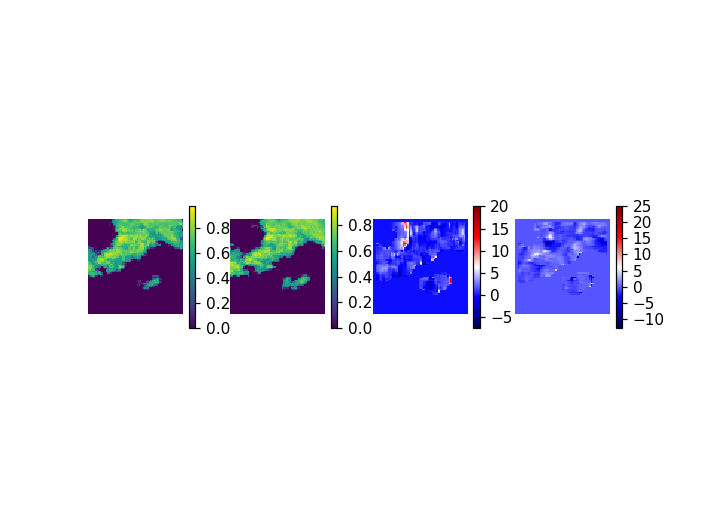

(-0.5, 63.5, 63.5, -0.5)

In [238]:
%matplotlib notebook

s = 3
plt.subplot(1,4,1)
plt.imshow(prev[s,:,:,0])
plt.colorbar(shrink=0.3)
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(curr[s,:,:,0])
plt.colorbar(shrink=0.3)
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(vx[s,:,:,0], cmap="seismic")
plt.colorbar(shrink=0.3)
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(vy[s,:,:,0], cmap="seismic")
plt.colorbar(shrink=0.3)
plt.axis('off')

<IPython.core.display.Javascript object>


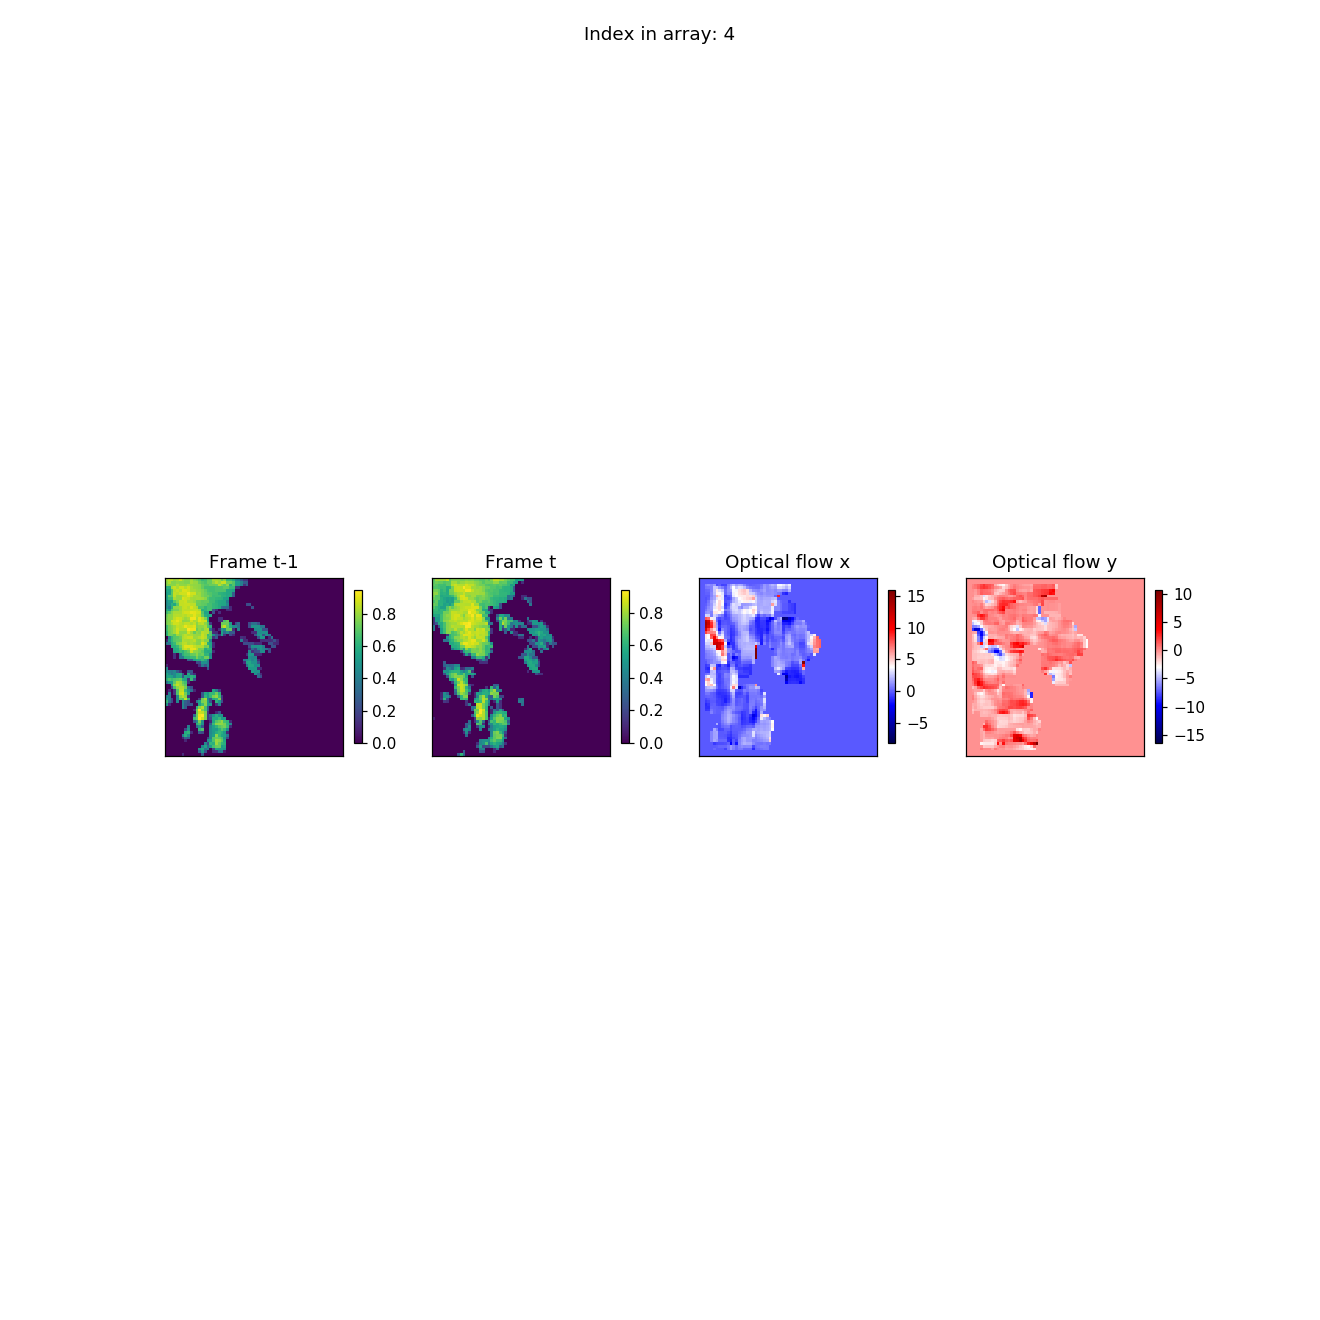

In [225]:
from  matplotlib.animation import FuncAnimation

%matplotlib notebook
#visualise channels
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(12,12))
for ax in [ax1,ax2,ax3,ax4]:
    ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,      # ticks along the top edge are off
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off
ax1.set_title("Frame t-1")
ax2.set_title("Frame t")
ax3.set_title("Optical flow x")
ax4.set_title("Optical flow y")
line1 = ax1.imshow(prev[0,:,:,0]) # start from index 0 which means 0:50:00
line2 = ax2.imshow(curr[0,:,:,0]) # start from index 1 which means 1:00:00
line3 = ax3.imshow(vx[0,:,:,0],cmap="seismic")
line4 = ax4.imshow(vy[0,:,:,0],cmap="seismic")
line = [line1, line2, line3, line4]

sh = 0.15
fig.colorbar(line1, ax=ax1,shrink=sh)
fig.colorbar(line2, ax=ax2,shrink=sh)
fig.colorbar(line3, ax=ax3,shrink=sh)
fig.colorbar(line4, ax=ax4,shrink=sh)

def run(i):
    line[0].set_data(prev[i,:,:,0])
    line[1].set_data(curr[i,:,:,0])
    line[2].set_data(vx[i,:,:,0])
    line[3].set_data(vy[i,:,:,0])
    fig.suptitle(f"Index in array: {i}")
    return line

ani = FuncAnimation(fig, run, blit=True, interval=2000, frames=500,
    repeat=False)
plt.show()